In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import pickle
import joblib
import time
import os

In [19]:
import pandas as pd
import pyreadr
result = pyreadr.read_r('../scotus/data/scotus_filtered.rda')
scotus_df = result["scotus_filtered"]

In [1]:
# for line in [f'{f[:-4]}_df = pd.read_csv("scotus/{f}")' for f in os.listdir("scotus") if f.endswith("csv")]:
#     print(line)

# print("{")
# for line in [f'\t"{f[:-4]}": {f[:-4]}_df,' for f in os.listdir("scotus") if f.endswith("csv")]:
#     print(line)
# print("}")

In [ ]:
bigram_df = pd.read_csv("../features/scotus/bigram.csv")
t5_scotus_embeddings_df = pd.read_csv("../features/scotus/t5_scotus_embeddings.csv")
paraphrase_scotus_embeddings_df = pd.read_csv("../features/scotus/paraphrase_scotus_embeddings.csv")
smoothed_unigram_df = pd.read_csv("../features/scotus/smoothed_unigram.csv")
unigram_df = pd.read_csv("../features/scotus/unigram.csv")
tfidf_df = pd.read_csv("../features/scotus/tfidf.csv")
sbert_df = pd.read_csv("../features/scotus/sbert.csv")
doc2vec_df = pd.read_csv("../features/scotus/doc2vec.csv")

In [ ]:
models = {
	"bigram": bigram_df,
	"t5_scotus_embeddings": t5_scotus_embeddings_df,
	"paraphrase_scotus_embeddings": paraphrase_scotus_embeddings_df,
	"smoothed_unigram": smoothed_unigram_df,
	"unigram": unigram_df,
	"tfidf": tfidf_df,
    "sbert": sbert_df,
    "doc2vec": doc2vec_df
}

In [22]:
def train_and_score_gbt(X, y, model_name, dataset_name="scotus"):
    # 1. Split Data
    X_train, X_test, y_train, y_test = train_test_split(X,y)

    # 2. Train GBT Model
    clf = GradientBoostingRegressor(n_estimators=100, learning_rate=1.0,
        max_depth=5, random_state=0)
    clf.fit(X_train,y_train)

    # 3. Get Predictions and Residuals
    y_pred = clf.predict(X_test)
    residuals = y_test - y_pred

    # 4. Score
    scores = {
        'model_name': model_name,
        'r2': r2_score(y_pred, y_test),
        'mea': mean_absolute_error(y_pred, y_test),
        'rmse': root_mean_squared_error(y_pred, y_test)
    }

    # 5. Plot
    plt.scatter(y_pred, residuals)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residual Plot: {model_name}')
    plt.axhline(y=0, color='r', linestyle='--')
    os.mkdir(f"results/{dataset_name}/{model_name}")
    plt.savefig(f"results/{dataset_name}/{model_name}/residuals.jpg")
    plt.clf()
    
    # 6. Save Model and Scores
    joblib.dump(clf, f"results/{dataset_name}/{model_name}/model_object.pkl")
    joblib.dump(clf, f"results/{dataset_name}/{model_name}/model_scores.pkl")

    return scores

In [41]:
scores_df = pd.DataFrame(columns=['model_name','r2','mea','rmse'])

for (model_name, features_df) in models.items():
    t0 = time.time()

    scores = train_and_score_gbt(
        X=features_df.to_numpy(), 
        y=scotus_df.year.apply(int).to_numpy(),
        model_name=model_name
    )
    scores_df = pd.concat([scores_df, pd.DataFrame([scores])], ignore_index=True)
    t1 = time.time()
    total = t1-t0
    print(f"Finished {model_name} in {total} seconds.")
    print(scores_df.head())

/var/folders/g9/m0c3tdxd4l7f9js2h3wz_fp40000gn/T/ipykernel_21915/324806241.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores_df = pd.concat([scores_df, pd.DataFrame([scores])], ignore_index=True)


Finished bigram in 46.890385150909424 seconds.
  model_name        r2        mea       rmse
0     bigram  0.865298  12.103389  18.382986
Finished t5_scotus_embeddings in 276.43545794487 seconds.
             model_name        r2        mea       rmse
0                bigram  0.865298  12.103389  18.382986
1  t5_scotus_embeddings  0.407667  30.858004  40.331869
Finished paraphrase_scotus_embeddings in 135.78380918502808 seconds.
                     model_name        r2        mea       rmse
0                        bigram  0.865298  12.103389  18.382986
1          t5_scotus_embeddings  0.407667  30.858004  40.331869
2  paraphrase_scotus_embeddings  0.317181  32.909617  43.401256
Finished smoothed_unigram in 50.89040493965149 seconds.
                     model_name        r2        mea       rmse
0                        bigram  0.865298  12.103389  18.382986
1          t5_scotus_embeddings  0.407667  30.858004  40.331869
2  paraphrase_scotus_embeddings  0.317181  32.909617  43.401256


<Figure size 640x480 with 0 Axes>

In [43]:
scores_df.to_csv("results/scotus/scores.csv")

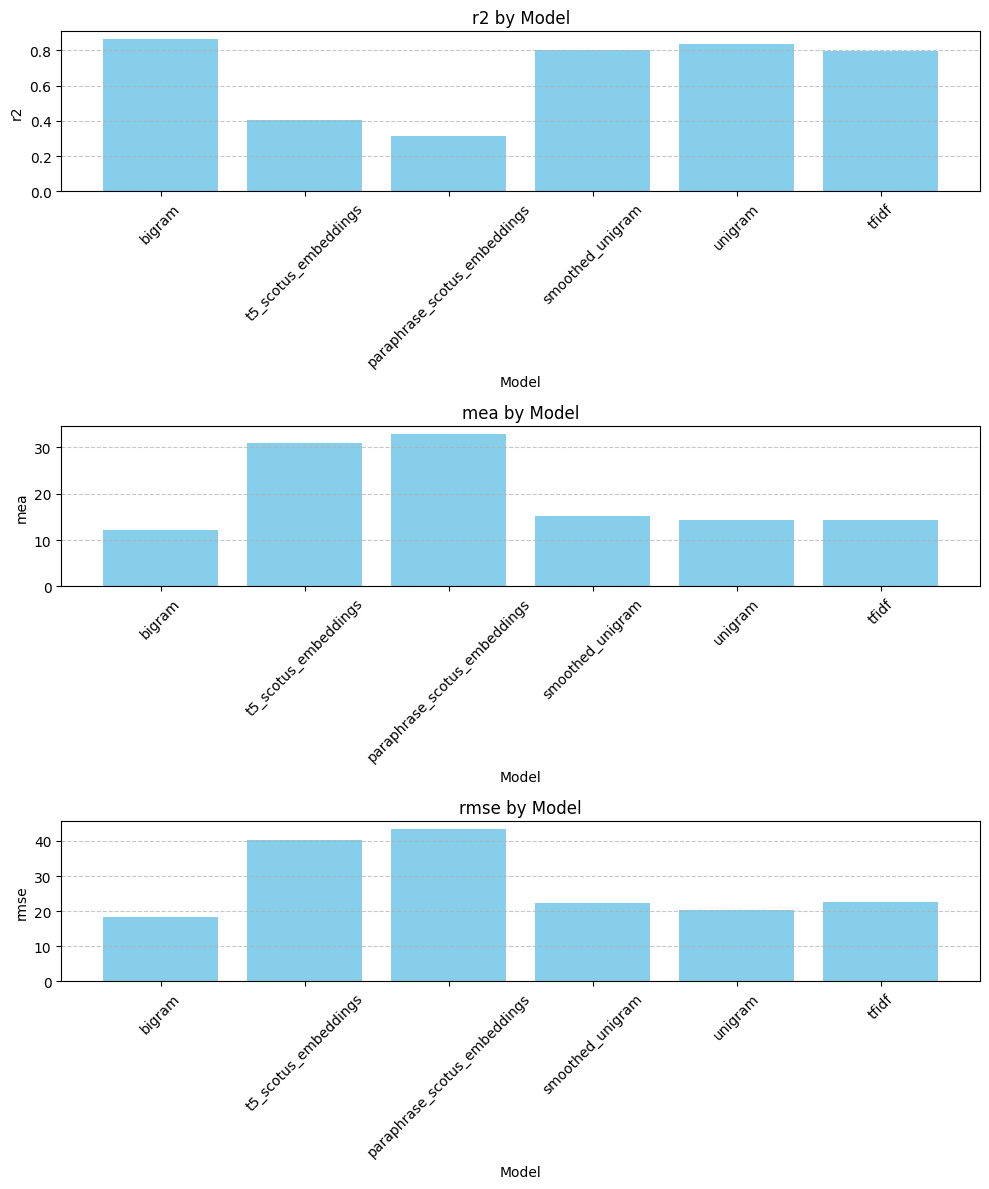

In [47]:
models = scores_df["model_name"]
scores = scores_df.iloc[:, 1:]  # All score columns
score_columns = scores.columns

# Bar width and positions
bar_width = 0.2
x = np.arange(len(models))  # Position of models on x-axis

plt.figure(figsize=(10, 12))

for i, (score_name, score_values) in enumerate(scores.items(), start=1):
    plt.subplot(3, 1, i)  # Create a subplot for each score
    plt.bar(models, score_values, color="skyblue")
    plt.title(f"{score_name} by Model")
    plt.xlabel("Model")
    plt.ylabel(score_name)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.xticks(rotation=45)
# Adjust layout
plt.tight_layout()
plt.show()